In [1]:
import sys
PATH_TO_ROOT='D:/My Repository'
sys.path.insert(0, PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import RBFInterpolator
from loess import loess_2d
import matplotlib.pyplot as plt

from AlphaMobileSensing.env import environment_v1

In [4]:
datapath='D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/static_50cm_DEMO.csv'
env=environment_v1.AlphaMoSeEnv(datapath, 2500, 1, 15, (3.5, 3), 2, (0.5, 0.5), 500)
action_series_df=pd.read_excel('D:/My Repository/AlphaMobileSensing/data/action series for demo.xlsx')

C:\Users\qizho\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
env.reset()
measurement_log=np.zeros(((len(action_series_df)+1),4))
measurement_log[0,:]=env.obs[:]
for i in range(len(action_series_df)):
    env.step(action_series_df.iloc[i,:].values)
    measurement_log[i+1,:]=env.obs[:]

Episode: 1
Total moving distance (m)
204.0
Total moving time (s)
1390.0


In [6]:
x=measurement_log[0:41,0]
y=measurement_log[0:41,1]
T=measurement_log[0:41,3]

X = np.linspace(-0.5, 73.55, 100)
Y = np.linspace(-3, 22.95, 100)
X, Y = np.meshgrid(X, Y) 

interp = NearestNDInterpolator(list(zip(x, y)), T)
Z = interp(X, Y)

In [7]:
data=env.stdata[['X', 'Y']]
delta=1.5

for i in range(100):
    for j in range(100):
        bb=np.array([X[0,i], Y[j,0]])
        judge_array=[0,0,0,0]
        window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
        (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
        judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
        judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
        judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
        judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
        if True in judge_array:
            Z[j,i]=np.nan 

(-0.5, 73.55, -3.0, 22.95)

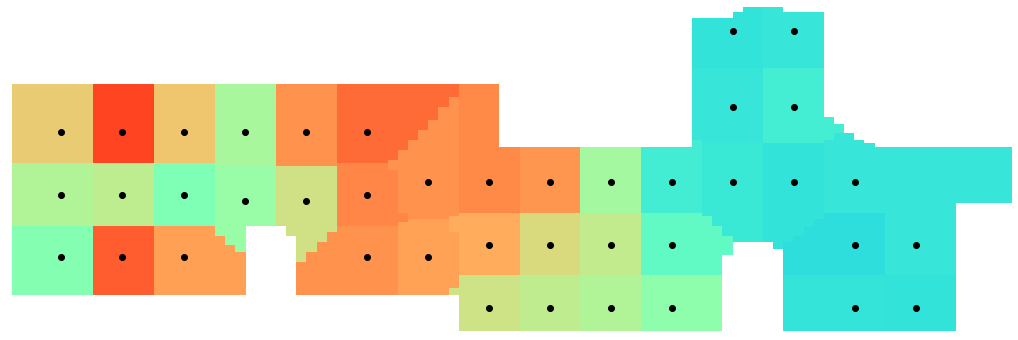

In [8]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(X, Y, Z, shading='auto', cmap='rainbow', vmin=293, vmax=313)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [12]:
env.request_evaluation()

In [13]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_NN.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values
Z=interp(X, Y)

for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_NN.csv', index=0)

env.compute_accuracy()

1.0944703058416385

In [ ]:
x=measurement_log[0:41,0]
y=measurement_log[0:41,1]
T=measurement_log[0:41,3]

xobs=np.zeros((41,2))
for i in range(41):
    xobs[i,0]=x[i]
    xobs[i,1]=y[i]

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T

yflat = RBFInterpolator(xobs, T)(xflat)

In [ ]:
delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        yflat[i]=np.nan 


ygrid = yflat.reshape(100, 100)

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=313)
im_m=ax.plot(x, y, "ok", label="input point")


ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [ ]:
env.request_evaluation()

In [ ]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_RBF.csv')

xflat=np.zeros((len(template),2))
xflat[:,0]=template.iloc[:,1].values
xflat[:,1]=template.iloc[:,2].values


Z = RBFInterpolator(xobs, T)(xflat)


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_RBF.csv', index=0)

env.compute_accuracy()

In [ ]:
x=measurement_log[0:41,0]
y=measurement_log[0:41,1]
z=measurement_log[0:41,3]

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T

newz=loess_2d.loess_2d(x,y,z, xflat[:,0], xflat[:,1])

In [ ]:
delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[0][i]=np.nan 


ygrid = newz[0].reshape(100, 100)

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=313)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [ ]:
env.request_evaluation()

In [ ]:
template=pd.read_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_LOWESS.csv')

xflat=np.zeros((len(template),2))
xflat[:,0]=template.iloc[:,1].values
xflat[:,1]=template.iloc[:,2].values

Z=loess_2d.loess_2d(x,y,z, xflat[:,0], xflat[:,1])


for i in range(len(template)):
    template.iloc[i,3]=Z[0][i]

template.to_csv('D:/My Repository/AlphaMobileSensing/demo/Template_demo_Static_LOWESS.csv', index=0)

env.compute_accuracy()